# Exploring Gephi Graph Streaming
Sources of information and inspiration:

[Gephi - Graph Streaming](https://github.com/gephi/gephi/wiki/GraphStreaming)

[Visualization of Large Dynamic Networks](http://www.eecs.wsu.edu/~yyao/DynamicGraph.html)


### Versions of software, packages, and libraries used:
- Python 3.6
- Jupyter Notebook 5.4.1
- Gephi 0.92
- requests 2.18.4
- numpy 1.14.2
- NetworkX 2.1
- Matplotlib 2.2.2

Notes:
- [NetworkX: Migration guide from 1.X to 2.0](https://networkx.github.io/documentation/stable/release/migration_guide_from_1.x_to_2.0.html)

# Setup and Foundation

## Turning on Gephi Master (Streaming)

- Run the Gephi application
- Create an empty workspace (File/New Project)
- Add some nodes and edges to your graph
- Go to the tab Streaming and right-click on the “Master Server” and select “Start”

## Start a Graph Stream

You can obtain a stream of graph events by making a `getGraph` request to Gephi. 

`curl "http://localhost:8080/workspace1?operation=getGraph"`

Note: this will not terminate, it is a live stream of Graph events that will run "forever" (that is, until Gephi Streaming is turned off, Gephi terminates, or the client requesting the stream is stopped).

## Gephi API
Based on [`GephiJsonClient`](http://www.eecs.wsu.edu/~yyao/DirectedStudyII/src/Citation/GephiJsonClient.py); modified for newer version of Python and newer version of Gephi. Also changed to use the [`requests`](http://docs.python-requests.org/en/master/) library, which also has the benefit of simplifying the implementation significantly.

In [66]:
import requests

### Parameters
**Where is Gephi running?**
- `host` = the name of the machine where Gephi is running
- `port` = the HTTP port for the Gephi REST API
- `workspace` = the number of the Gephi workspace

In [67]:
host = "localhost"
port = 8080
workspace = 1

### form a URL from the parameters

In [297]:
def gephiURL(host, port, workspace):
    return "http://{}:{}/workspace{}?operation=updateGraph".format(host, port, workspace)

In [298]:
url = gephiURL(host, port, workspace)

In [299]:
url

'http://localhost:8080/workspace1?operation=updateGraph'

### access functions

In [97]:
def post(content):
    #print(content)
    response = requests.post(url, json=content)
    return response

In [98]:
def addVertex(node, attr={}):
    content = {"an":{""+node:attr}}
    return post(content)

In [99]:
def removeVertex(node):
    content = {"dn":{""+node:{}}}
    return post(content)

In [311]:
def changeVertex(node, attr={}):
    content = {"cn":{""+node:attr}}
    return post(content)

In [100]:
def addEdge(eid, source, target, directed=False, weight=1.0):
    attributes = {}
    attributes['source'] = source;
    attributes['target'] = target;
    attributes['directed'] = directed;
    attributes['weight'] = weight
    content = {"ae": {eid:attributes}}
    return post(content)

In [101]:
def removeEdge(eid):
    content = {"de":{eid:{}}}
    return post(content)

### convenience functions

In [91]:
def addNode(node):
    return addVertex(node, {'label':node})

In [92]:
def addLink(source, target, directed=False, weight=1.0):
    return addEdge("{}-{}".format(source, target), source, target, directed, weight)

In [93]:
'''
connect(node, neighbors)
  connect a node to list of neighbors
  
  Inputs:
    node = the source node
    neighbors = a list of target neighbors
'''
def connect(node, neighbors):
    for neighbor in neighbors:
        addLink(node, neighbor)

In [94]:
'''
newNode(node, neighbors)
  Create a node node and connect to a list of neighbors
  
  Inputs:
    node = the new node to be added
    neighbors = a list of neighbors
'''
def newNode(node, neighbors):
    addNode(node)
    connect(node, neighbors)

In [180]:
def deleteNode(graph, node):
    result = removeVertex(str(node))
    graph.remove_node(node)
    return

### create a graph in Gephi from various formats

#### custom format

This custom format is a multi-level Python dictionary. The top-level keys represent the vertices of the graph. The values are dictionaries which designate directed edges where the keys are the target vertices and the values are the weights.

In [78]:
graph = {
    's': {'a': 2, 'b': 1},
    'a': {'s': 3, 'b': 4, 'c': 8},
    'b': {'s': 4, 'a': 2, 'd': 2},
    'c': {'a': 2, 'd': 7, 't': 4},
    'd': {'b': 1, 'c': 11, 't': 5},
    't': {'c': 3, 'd': 5}
}

In [79]:
'''
createGraph(graph)
  Create a graph in Gephi from custom graph format
  
  Inputs:
    graph = graph in custom format
    
  Notes:
    Creates an undirected and unweighted graph, despite the fact 
    that the custom format allows specifying directed and weighted.
'''
def createGraph(graph):
    for node in graph:
        response = addNode(node)
    for node in graph:
        for neighbor in graph[node]:
            response = addLink(node, neighbor)

#### NetworkX

In [85]:
'''
createGraphNx(graph)
  Create a graph in Gephi from a NetworkX graph
  
  Inputs:
    graph = a NetworkX graph
    
  Notes:
    Creates an undirected and unweighted graph.
'''
def createGraphNx(graph):
    for node in graph.nodes():
        result = addNode(str(node))
    for edge in g.edges():
        source = edge[0]
        target = edge[1]
        result = addLink(str(source), str(target))

## Network Creation functions

In [121]:
import numpy as np
import networkx as nx

'''
barabasi_albert_graph(n, m=1):
    a function that takes `n` the number of nodes for the graph, 
    and `m` the initial number of nodes, as arguments and returns a networkx 
    graph with a scale-free degree distribution.
'''
def barabasi_albert_graph(n, m=1):
    # create a complete graph with m initial nodes. 
    # (note: we could use nx.complete_graph() here, but opt to do the creation manually
    # to keep the `type` of the graph created as Graph instead of Complete Graph)
    g = nx.Graph()
    for i in range(m):
        g.add_node(i)
        for j in range(i+1,m):
            g.add_edge(i,j)
    
    # while network has less than n nodes, 
    for i in range(m, n):
        # 1. preferentially sample m nodes from the network,
        nodes = g.nodes()
        degrees = list(g.degree().values())
        sum_degrees = sum(degrees)
        node_probs = [x*1.0/sum_degrees for x in degrees]
        selected = np.random.choice(nodes, size=m, replace=False, p = node_probs)
        # 2. create a new node, 
        g.add_node(i)
        # 3. and connect the new node to the m selected nodes.
        for s in selected:
            g.add_edge(i, s)
    
    return g

In [160]:
import numpy as np
import networkx as nx

'''
barabasi_albert_graph(n, m=1):
    a function that takes `n` the number of nodes for the graph, 
    and `m` the initial number of nodes, as arguments and returns a networkx 
    graph with a scale-free degree distribution.
'''
def barabasi_albert_graph_without_using_degree(n, m=1):
    # create a complete graph with m initial nodes. 
    # (note: we could use nx.complete_graph() here, but opt to do the creation manually
    # to keep the `type` of the graph created as Graph instead of Complete Graph)
    g = nx.Graph()
    for i in range(m):
        g.add_node(i)
        for j in range(i+1,m):
            g.add_edge(i,j)
    
    # while network has less than n nodes, 
    for i in range(m, n):
        # get the list of edges
        edges = [e for e in g.edges]
        # randomly select m of the edges with equal probability
        selected = np.random.choice(len(edges), m, replace=False)
        # create a new node
        g.add_node(i)
        for s in selected:
            # for each of the selected edges, randomly pick one of the nodes
            linkTo = np.random.choice(edges[s], 1)[0]
            # and add an edge from the new node to that node
            g.add_edge(i, linkTo)
    
    return g

## Plotting and Supporting funtions

In [ ]:
def averageDegree(G):
    return sum(G.degree().values())/len(G.nodes())

In [ ]:
def probabilityForDegree(N, k):
    return k/(N-1)

In [269]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def showDegreeDistribution(graph):
    degrees = sorted([d[1] for d in graph.degree()])
    (v, e, p) = plt.hist(degrees)
    
def showDegreeDistributionWithFit(graph):
    degrees = sorted([d[1] for d in graph.degree()])
    (y, x, p) = plt.hist(degrees)
    y = np.append(y, [0])
    z = np.polyfit(x, y, 3)
    f = np.poly1d(z)
    x_new = np.linspace(x[0], x[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, "r")
    plt.xlim([x[0]-1, x[-1] + 1 ])
    plt.show()

In [177]:
def nodeWithHighestDegree(graph):
    return sorted(list(graph.degree()), key=lambda x: x[1], reverse=True)[0][0]

In [288]:
def removeTopN(graph, percent):
    number = int(len(graph.nodes()) * (percent/100))
    print("Deleting top {} percent with highest degree ({} nodes)".format(percent, number))
    for i in range(number):
        n = nodeWithHighestDegree(graph)
        deleteNode(graph, n)

# Exploration: Static Analysis

## Erdos-Renyi (random) graph

**Set the Gephi URL**

In [300]:
url = gephiURL(host, port, 1)

**Create the graph, and show the degree distribution**

In [292]:
import networkx as nx
g = nx.erdos_renyi_graph(500, 0.01)

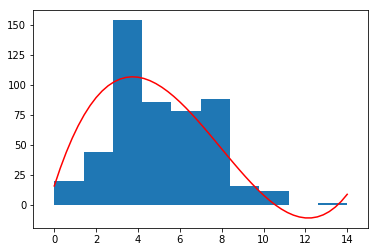

In [293]:
showDegreeDistributionWithFit(g)

**Display the graph in Gephi**

In [294]:
%%time
createGraphNx(g)

CPU times: user 4.23 s, sys: 709 ms, total: 4.94 s
Wall time: 6.3 s


**Remove 10 percent of nodes based on highest degree, and look at the degree distribution again**

In [295]:
removeTopN(g, 10)

Deleting top 10 percent with highest degree (50 nodes)


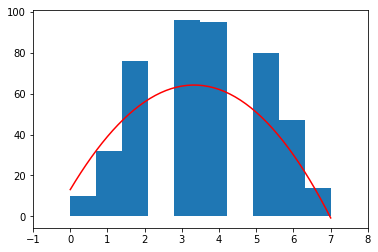

In [296]:
showDegreeDistributionWithFit(g)

## Barabasi-Albert graph

**Set the Gephi URL**

In [301]:
url = gephiURL(host, port, 2)

**Create the graph, and show the degree distribution**

In [302]:
N = 500
m_o = 7
g = barabasi_albert_graph_without_using_degree(N, m_o)

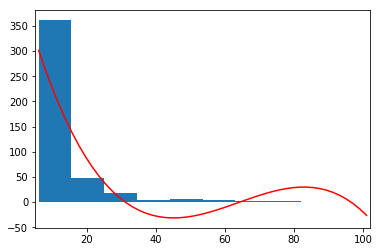

In [303]:
showDegreeDistributionWithFit(g)

**Display the graph in Gephi**

In [305]:
%%time
createGraphNx(g)

CPU times: user 8.38 s, sys: 1.24 s, total: 9.62 s
Wall time: 12.4 s


**Remove 10 percent of nodes based on highest degree, and look at the degree distribution again**

In [306]:
removeTopN(g, 10)

Deleting top 10 percent with highest degree (45 nodes)


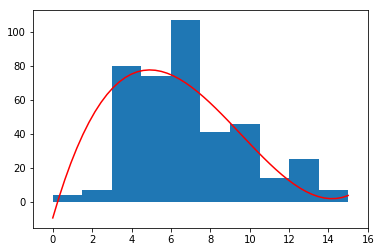

In [307]:
showDegreeDistributionWithFit(g)

# Exploring: Dynamic Graph

- what will be the starting point?
- probably a BA graph (Power Law degree distribution)
- what is the normal dynamic nature?
- adding vertices, and edges
- at what rate?
- how will we control time?
- what are the different fault models?
  - what are the targets? (vertices or edges)
  - failure: random target selected
  - attack: specific target selected
- how are the fault models controlled?
- what is the measure for robustness?
- how will we show the robustness measure?

Ultimately I would like to define, model, and run the simulation from the Jupyter Nodebook. The activity should be visible in the Jupyter Notebook (i.e., printing messages about actions taking place), observe the live activity in Gephi, and at periodic intervals export data which can be displayed in Cubix (separately, after the simulation completes).

In [ ]:
import time

In [ ]:
time.sleep(3)

In [308]:
url = gephiURL(host, port, 3)

In [310]:
addVertex('a', {'label':'a', 'color':'#00ff00'})

<Response [200]>

In [312]:
changeVertex('a', {'label':'a', 'color':'#ff0000'})

<Response [200]>

In [317]:
changeVertex('a', {'label':'a', 'color':'#0000ff'})

KeyboardInterrupt: 